In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn import linear_model
from torch import nn
import torch



In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [40]:
df = pd.read_csv("Data/crop_yield_data.csv")

In [41]:
def preprocess(df):
    # df = df.dropna()
    # df = df[df["Crop"]=="Avocados"]
    # df = df.drop(columns="Crop", axis=1)
    # df = df.drop(columns="Year", axis=1)
    df['Export Quantity'] = df['Export Quantity'].interpolate(method='linear', limit_direction='backward', axis=0)
    scaler = preprocessing.StandardScaler()
    scal_feat = ['Temperature (Avg)','Precipitation','Export Quantity','Fertilizer Usage']
    df[scal_feat]=scaler.fit_transform(df[scal_feat].to_numpy())
    feat = scal_feat + ["Crop"]
    X = df[feat].copy(deep=True)
    X = pd.get_dummies(X, columns = ['Crop'])
    y = df['Yield'].copy(deep=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 13)

    return X_train, X_test, y_train, y_test, X
    

In [14]:
def compute_scores(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse) 
    r2 = metrics.r2_score(y_test, y_pred)
    print("MAE : ",mae)
    print("MSE : ",mse)
    print("RMSE : ",rmse)
    print("R2 : ",r2)

In [57]:
X_train, X_test, y_train, y_test, X = preprocess(df)

In [ ]:
correlation_matrix = pd.DataFrame(X).corr()
plt.matshow(correlation_matrix)
plt.show()

#### Linear Regression

In [15]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
y_pred_linear= model_lin.predict(X_test)
compute_scores(y_test, y_pred_linear)

MAE :  14735.196362244102
MSE :  413785184.80689985
RMSE :  20341.710469055935
R2 :  0.8316633489066173


#### Decision Tree

In [16]:
dt_regression = DecisionTreeRegressor()
dt_regression.fit(X_train, y_train)
y_pred_dt = dt_regression.predict(X_test)
compute_scores(y_test, y_pred_dt)

MAE :  10626.416666666666
MSE :  248188971.79166666
RMSE :  15754.014465896198
R2 :  0.8990314252811727


#### KNN

In [23]:
kNN = KNeighborsRegressor(n_neighbors=10) #tweak number of neighbours
kNN.fit(X_train, y_train)
y_pred_knn = kNN.predict(X_test)
compute_scores(y_test, y_pred_knn)

MAE :  12449.214583333334
MSE :  429741854.4960417
RMSE :  20730.215978036547
R2 :  0.8251718348633416


#### Shrinkage - Ridge

In [19]:
ridge_regression = Ridge(alpha=1.0, solver = 'auto', random_state = 13) #if we use alpha = 0, it becomes simple LR problem, solver = ‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’
ridge_regression.fit(X_train, y_train)
y_pred_ridge = ridge_regression.predict(X_test)
compute_scores(y_test, y_pred_ridge)

MAE :  14790.581353713394
MSE :  420434163.38418055
RMSE :  20504.491297864002
R2 :  0.8289584024078358


#### Shrinkage - Lasso

In [20]:
lasso_regression = linear_model.Lasso(alpha=0.1, random_state = 13)
lasso_regression.fit(X_train, y_train)
y_pred_lasso = lasso_regression.predict(X_test)
compute_scores(y_test, y_pred_lasso)

MAE :  14735.211625845215
MSE :  413786300.6856904
RMSE :  20341.737897379622
R2 :  0.8316628949432916


In [26]:
class CropPredictor(nn.Module):
    def __init__(self, input_features, hidden_units) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=1)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

torch.manual_seed(13)
model_0 = CropPredictor(len(X_train.columns), 5)
model_0

CropPredictor(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=8, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ReLU()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [27]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [52]:
torch.tensor(X_train[:].values)

tensor([[-0.9102, -0.7440, -0.5786,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2992,  0.0197,  1.9106,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.2992,  0.0197, -0.5780,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-1.3939,  0.8094, -0.5639,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.9922,  1.0766, -0.4514,  ...,  0.0000,  1.0000,  0.0000],
        [-0.5992,  1.5948, -0.5638,  ...,  1.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [45]:
torch.tensor(X_train)

ValueError: could not determine the shape of object type 'DataFrame'

In [33]:
l = X_train.to_numpy()

In [61]:
torch.manual_seed(13)

# Set the number of epochs 
epochs = 10000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
# X_train = torch.tensor(X_train[:].values).float()
# X_test = torch.tensor(X_test[:].values).float()
# y_train = torch.tensor(y_train[:].values).float()
# y_test = torch.tensor(y_test[:].values).float()

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    model_0.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_0.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_0(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 33355.8984375 | Test loss: 38635.609375
Epoch: 100 | Train loss: 33324.515625 | Test loss: 38633.7578125
Epoch: 200 | Train loss: 33380.984375 | Test loss: 38633.37890625
Epoch: 300 | Train loss: 33368.2265625 | Test loss: 38634.8046875
Epoch: 400 | Train loss: 33312.921875 | Test loss: 38630.10546875
Epoch: 500 | Train loss: 33343.98046875 | Test loss: 38634.359375
Epoch: 600 | Train loss: 33371.43359375 | Test loss: 38635.578125
Epoch: 700 | Train loss: 33392.35546875 | Test loss: 38633.171875
Epoch: 800 | Train loss: 33295.99609375 | Test loss: 38636.21484375
Epoch: 900 | Train loss: 33359.88671875 | Test loss: 38636.76171875
Epoch: 1000 | Train loss: 33370.39453125 | Test loss: 38634.9921875
Epoch: 1100 | Train loss: 33378.109375 | Test loss: 38632.8984375
Epoch: 1200 | Train loss: 33288.203125 | Test loss: 38635.15234375
Epoch: 1300 | Train loss: 33288.69140625 | Test loss: 38634.75
Epoch: 1400 | Train loss: 33307.94140625 | Test loss: 38626.95703125
Epoch: 

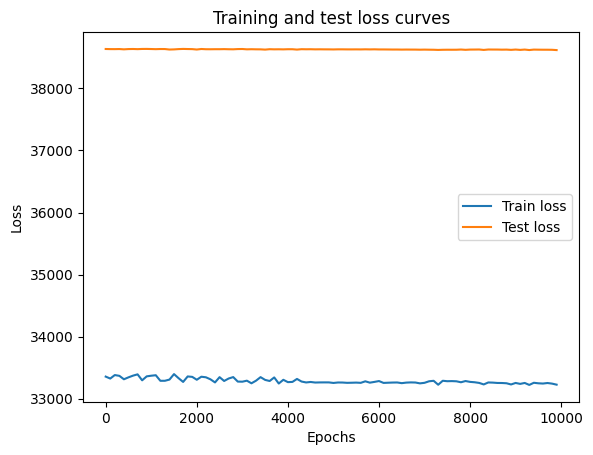

In [62]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();